# Homework 3

This assignment covers Harris corner detector, RANSAC and HOG descriptor.

Bài tập này bao gồm: bộ phát hiện góc Harris, phương pháp RANSAC và bộ mô tả đặc trưng HOG. Dùng nó để làm một ứng dụng ghép hình Pananoma đơn giản.

In [25]:
# Setup
from __future__ import print_function
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time



%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

print ("Nguyen Anh Duy B1509854")
print ("Họ va ten 2 (MSSV)")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Nguyen Anh Duy B1509854
Họ va ten 2 (MSSV)


## Introduction: Panorama Stitching
Panorama stitching is an early success of computer vision. Matthew Brown and David G. Lowe published a famous [panoramic image stitching paper](http://matthewalunbrown.com/papers/ijcv2007.pdf) in 2007. Since then, automatic panorama stitching technology has been widely adopted in many applications such as Google Street View, panorama photos on smartphones,
and stitching software such as Photosynth and AutoStitch.

Ghép ảnh panorama là một trong ứng dụng thành công đầu tiên của thị giác máy tính. Mathew Brown và David G. Lowe đã công bố một bài báo nổi tiếng vào năm 2007. Từ đó, công nghệ ghép ảnh panorama tự động đã được sử dụng rộng rãi trong nhiều ứng dụng như Google Street View, ảnh panorama trên điện thoại thông minh và các phần mềm ghép ảnh như Photosynth and AutoStitch.

In this assignment, we will detect and match keypoints from multiple images to build a single panoramic image. This will involve several tasks:

Trong bài tập này, ta sẽ phát hiện so khớp (đối sánh) các keyoints từ nhiều ảnh và ghép thành một ảnh panorama duy nhất. Quá trình này gồm nhiều bước:

1. Use Harris corner detector to find keypoints.

Sử dụng bộ phát hiện góc Harris để tìm các keypoints

2. Build a descriptor to describe each point in an image. <br>
   Compare two sets of descriptors coming from two different images and find matching keypoints.

Với mỗi keypoint xây dựng một bộ mô tả cho nó (tính vector đặc trưng cho mỗi keypoint).<br>
So sánh hai tập các vector đặc trưng của hai ảnh để tìm các cặp keypoints khớp với nhau.

3. Given a list of matching keypoints, use least-squares method to find the affine transformation matrix that maps points in one image to another.

Với một danh sách các cặp keypoint khớp với nhau đã cho, sử dụng phương pháp bình phương tối thiểu để tìm biến đổi affine (một phép biến đổi hình học) để biến đổi những điểm trong ảnh này thành những điểm tương ứng trong điểm kia.

4. Use RANSAC to give a more robust estimate of affine transformation matrix. <br>
   Given the transformation matrix, use it to transform the second image and overlay it on the first image, forming a panorama.
   
Sử dụng kỹ thuật RANSAC để tìm một ma trận biến đổi affine tốt nhất (ta đã sử dụng kỹ thuật này trong tìm đường thẳng tốt nhất, nay áp dụng nó để tìm ma trận tốt nhất).<br>
Với ma trận biến đổi tìm thầy, sử dụng nó để biến đổi ảnh thứ hai và chồng nó lên ảnh thứ nhất. Như thế sẽ tạp nên ảnh panorama !
   
5. Implement a different descriptor (HOG descriptor) and get another stitching result.

Trong phần 2, đầu tiên ta sẽ sử dụng một bộ mô tả rất đơn giản, đó là: trải dài vùng ảnh xung quanh keypoint để thu được một vector các mức xám của các điểm này. Vector đặc trưng thu được từ bộ mô tả này thường không có tính phân biệt cao nên kết quả thường không tốt. Trong phần này, ta cài đặt thêm một bộ mô tả (vector đặc trưng) khác nữa, đó là bộ mô tả HOG. Và làm lại quá trình ghép ảnh, ta sẽ thu được kết quả tốt hơn.


## Part 1 Harris Corner Detector (20 points)


In this section, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector to understand how it works. The Harris detection algorithm can be divide into the following steps:

Trong phần này, bạn sẽ cài đặt bộ phát hiện góc Harris để định vị các keypoint. Hãy xem lại các slides trong phần lý thuyết về bộ phát hiện góc Harris (các slides 43 - 62) để hiểu thêm về các thức hoạt động của nó. Giải thuật phát hiện góc Harris gồm các bước sau:

1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image

Tính đạo hàm riêng theo $x$ và $y$ ($I_x, I_y$) của ảnh

2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel

Tính tích các đạo hàm ($I_x^2, I_y^2, I_{xy}$) tại mỗi điểm

$$
I_x^2 = I_x.I_x\\
I_y^2 = I_y.I_y\\
I_{xy} = I_x.I_y
$$

3. Compute matrix $M$ at each pixel, where

Với mỗi điểm ảnh (x,y) tính ma trận $M$ theo công thức

$$
M = \sum_{x,y} w(x,y)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
$M$ là một ma trận $2\times2$.

4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel

Tính ma trận kết quả R bằng cách tính $R=Det(M)-k(Trace(M)^2)$ tại mỗi điểm.

5. Output corner response map $R(x,y)$

Trả về ma trận $R(x,y)$.

Step 1 is already done for you in the function **`harris_corners`** in `panorama.py`. Complete the function implementation and run the code below.

Trong hàm **`harris_corners`** trong `panorama.py`, người ta đã làm xong bước 1 rồi. Hãy hoàn tất các bước còn lại và chạy đoạn code bên dưới.

*-Hint: You may use the function `scipy.ndimage.filters.convolve`, which is already imported in `panoramy.py`*

*-Gợi ý: Có thể bạn cần dùng tới hàm `scipy.ndimage.filters.convolve`. Hàm này đã được import trong `panoramy.py` rồi.*



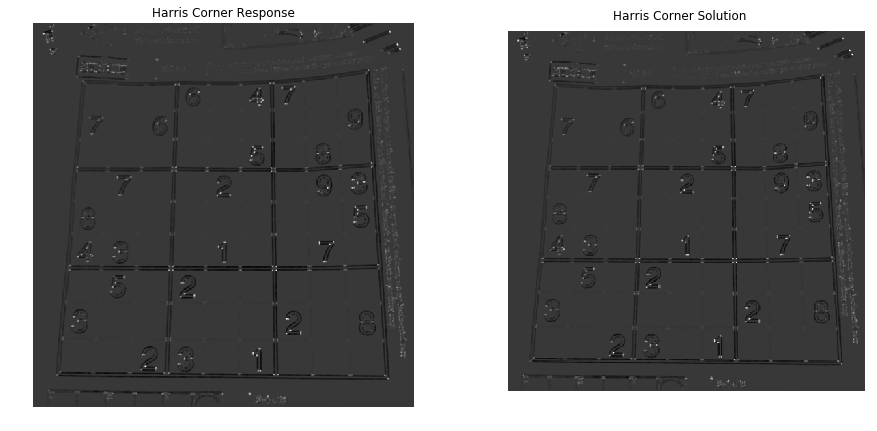

In [26]:
from panorama import harris_corners

img = imread('sudoku.png', as_grey=True)

# Compute Harris corner response
response = harris_corners(img)

# Display corner response
plt.subplot(1,2,1)
plt.imshow(response)
plt.axis('off')
plt.title('Harris Corner Response')

plt.subplot(1,2,2)
plt.imshow(imread('solution_harris.png', as_grey=True))
plt.axis('off')
plt.title('Harris Corner Solution')

plt.show()

Once you implement the Harris detector correctly, you will be able to see small bright blobs around the corners of the sudoku grids and letters in the output corner response image. The function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints.

Một khi bạn đã cài đúng bộ phát hiện góc Harris, bạn sẽ thấy một những đốm sáng nhỏ xung quanh các góc của lưới sudoku và góc của các ký tự trong ảnh kết quả R. Hàm `corner_peaks` từ `skimage.feature` thực hiện xoá các điểm không cực trị giữ lại các điểm cực trị cục bộ và định vị các keypoints.

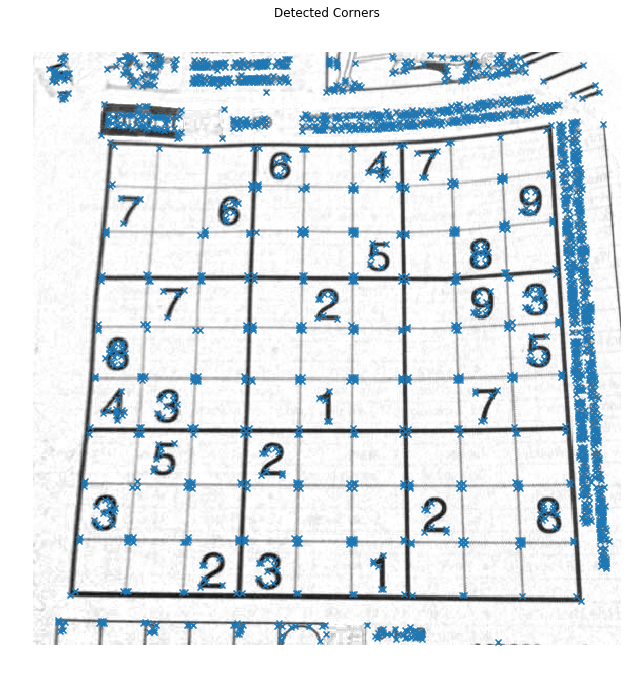

In [27]:
# Perform non-maximum suppression in response map
# and output corner coordiantes
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
plt.imshow(img)
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()

## Part 2 Describing and Matching Keypoints (20 points)

We are now able to localize keypoints in two images by running the Harris corner detector independently on them. Next question is, how do we determine which pair of keypoints come from corresponding locations in those two images? In order to *match* the detected keypoints, we must come up with a way to *describe* the keypoints based on their local appearance. Generally, each region around detected keypoint locations is converted into  a fixed-size vectors called *descriptors*.

Sau khi đã cài đặt được giải bộ phát hiện góc Harris, giờ đây ta có thể định vị được các keypoints trên hai ảnh bằng cách gọi hàm **harris_corners** độc lập trên từng ảnh. Câu hỏi tiếp theo là làm thể nào để xác định đượccasc cặp keypoint tương ứng với nhau trong hai ảnh này? Để *so khớp* các keypoint, ta phải tìm cách *mô tả* các keypoint dựa trên vùng ảnh xung quanh keypoint. Một cách tổng quát, vùng ảnh xung quanh keypoint sẽ được biến đổi thành một vector có kích thước giống nhau, và gọi là *bộ mô tả* hay *vector đặc trưng* của keypoint.


### Part 2.1 Creating Descriptors (10 points)

In this section, you are going to implement a **`simple_descriptor`**; each keypoint is described by normalized intensity in a small patch around it.

Trong phần này, bạn sẽ cài đặt một **`bộ mô tả đơn giản`**; mỗi keypoint được mô tả bằng cường độ sáng (mức xám) chuẩn hoá của các pixel trong một vùng ảnh nhỏ xung quanh keypoint. Các bước thực hiện:

- Trải dài vùng ảnh patch kích thước (H x W) thành một mảng 1 chiều kích thước H\*W, gọi mảng này là **`feature`**.
- Tính giá trị trung bình của các phần tử của **`feature`**
- Tính độ lệch chuẩn của các phần tử của **`feature`**
- Chuẩn hoá các phần tử của **`feature`** bằng cách trừ cho giá trị trung bình và lấy kết quả chia cho độ lệch chuẩn.

Hãy viết hàm **`simple_descriptor`**.


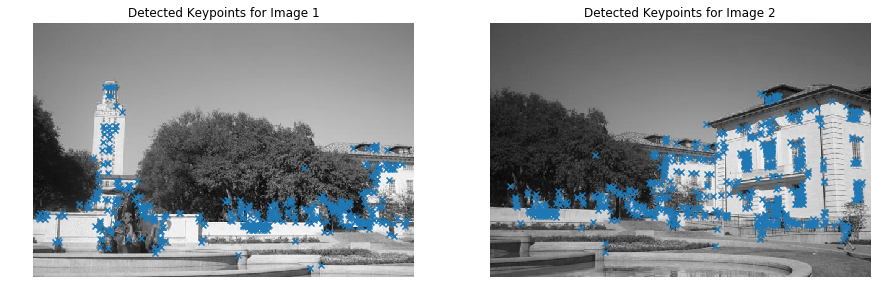

In [29]:
from panorama import harris_corners

img1 = imread('uttower1.jpg', as_grey=True)
img2 = imread('uttower2.jpg', as_grey=True)

# Detect keypoints in two images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

### Part 2.2 Matching Descriptors (10 points)
Then, implement **`match_descriptors`** function to find good matches in two sets of descriptors. First, calculate Euclidean distance between all pairs of descriptors from image 1 and image 2. Then use this to determine if there is a good match: if the distance to the closest vector is significantly (by a factor which is given) smaller than the distance to the second-closest, we call it a match. The output of the function is an array where each row holds the indices of one pair of matching descriptors.


Tiếp theo, cài hàm **`match_descriptors`** để tìm các cặp keypoint khớp nhau từ hai tập hợp các bộ mô tả. Trước hết, tính khoảng cách Euclide giữa tất cả các cặp mô tả từ ảnh 1 và ảnh 2. Sau đó, dùng các khoảng cách này để tìm các cặp keypoint khớp nhau.

Giả sử ta đang xét keypoint i của ảnh 1 có bộ mô tả là desc1[i,].
- Ta tìm hai keypoint trong ảnh 2 có bộ mô tả gần với desc1[i, ] nhất. Gọi keypoint gần nhất là j và keypoint gần nhì là k (hay dist[i, j] < dist[i, k]).
- Nếu dist[i, j] **nhỏ hơn nhiều** so với dist[i, k] thì (i, j) là một cặp keypoint khớp với nhau. Trong bản cài đặt này, khái niệm **nhỏ hơn nhiều** được hiểu là tỷ lệ của hai khoảng cách nhỏ hơn một ngưỡng nào đó (theo công thức của David G. Lowe):
$$dist[i, j]/dist[i, k] < threshold$$




N: 397
(397, 25)
(629, 25)
(397, 629)


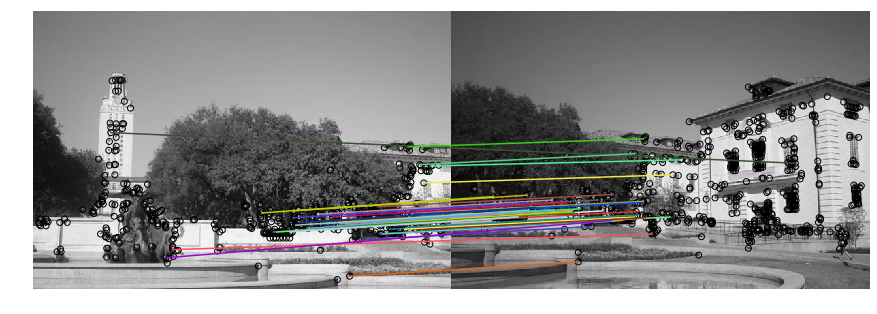

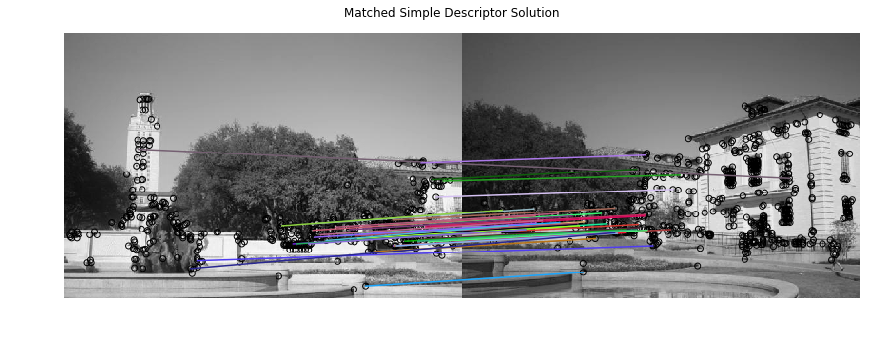

In [32]:
from panorama import simple_descriptor, match_descriptors, describe_keypoints
from utils import plot_matches

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
plt.imshow(imread('solution_simple_descriptor.png'))
plt.axis('off')
plt.title('Matched Simple Descriptor Solution')
plt.show()

## Part 3 Transformation Estimation (20 points)

We now have a list of matched keypoints across the two images. We will use this to find a transformation matrix that maps points in the second image to the corresponding coordinates in the first image. In other words, if the point $p_1 = [y_1,x_1]$ in image 1 matches with $p_2=[y_2, x_2]$ in image 2, we need to find an affine transformation matrix $H$ such that

Giờ đây ta đã có một danh sách các cặp keypoint khớp nhau của hai ảnh. Ta sẽ dùng nó để tìm một ma trận biến đổi hình học để biến đổi các điểm của ảnh 2 thành các điểm tương ứng trong hệ toạ độ của ảnh 1. Nói cách khác, nếu điểm $p_1 = [y_1,x_1]$ trong ảnh 1 khới với điểm $p_2=[y_2, x_2]$ trong ảnh 2, ta sẽ tìm một ma trận biến đổi hình học (biến đổi affine) $H$ sao cho

$$
\tilde{p_2}H = \tilde{p_1},
$$

where $\tilde{p_1}$ and $\tilde{p_2}$ are homogenous coordinates of $p_1$ and $p_2$.

trong đó $\tilde{p_1}$ và $\tilde{p_2}$ là toạ độ thuần nhất của $p_1$ $p_2$ (xem lại môn đồ hoạ máy tính để biết thêm về toạ độ thuần nhất).


Note that it may be impossible to find the transformation $H$ that maps every point in image 2 exactly to the corresponding point in image 1. However, we can estimate the transformation matrix with least squares. Given $N$ matched keypoint pairs, let $X_1$ and $X_2$ be $N \times 3$ matrices whose rows are homogenous coordinates of corresponding keypoints in image 1 and image 2 respectively. Then, we can estimate $H$ by solving the least squares problem,

Chú ý là có thể bạn sẽ không tìm được ma trận $H$ để biến đổi chính xác mỗi điểm trong ảnh 2 thành 1 điểm tương ứng trong ảnh 1. Tuy nhiên, ta có thể tìm được một ma trận xấp xỉ gần đúng với ma trận lý tưởng bằng phương pháp bình phương nhỏ nhất. Cho $N$ cặp keypoint khớp nhau, gọi $X_1$ và $X_2$ là các ma trận kích thước $N \times 3$ với hàng của nó là các toạ độ thuần nhất của các keypoints tương ứng trong ảnh 1 và ảnh 2. Ta có thể ước lượng $H$ bằng cách giải bài toán bình phương nhỏ nhất sau:

$$
X_2 H = X_1
$$

Implement **`fit_affine_matrix`** in `panorama.py`

*-Hint: read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) about np.linalg.lstsq*


*-Gợi ý:
Đây là một bài toán giải hệ phương trình tuyến tính có số phương trình nhiều hơn biến. Bạn có thể sử dụng phương pháp nghịch đảo ma trận giả (pseudo-inverse) hoặc phép chia ma trận để tìm $H$. Xem thêm tài liệu về bước này trong bộ slides **03_linalg_review**.
Nên đọc thêm tài liệu [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) về hàm giải bài toán bình phương nhỏ nhất **np.linalg.lstsq***

In [11]:
from panorama import fit_affine_matrix

# Sanity check for fit_affine_matrix

# Test inputs
a = np.array([[0.5, 0.1], [0.4, 0.2], [0.8, 0.2]])
b = np.array([[0.3, -0.2], [-0.4, -0.9], [0.1, 0.1]])

H = fit_affine_matrix(b, a)

# Target output
sol = np.array(
    [[1.25, 2.5, 0.0],
     [-5.75, -4.5, 0.0],
     [0.25, -1.0, 1.0]]
)

error = np.sum((H - sol) ** 2)

if error < 1e-20:
    print('Implementation correct!')
else:
    print('There is something wrong.')

Implementation correct!


After checking that your `fit_affine_matrix function` is running correctly, run the following code to apply it to images.
Images will be warped and image 2 will be mapped to image 1. Then, the two images are merged to get a panorama. Your panorama may not look good at this point, but we will later use other techniques to get a better result.

Sau khi kiểm tra hàm `fit_affine_matrix function` chạy chính xác, hãy chạy đoạn code bên dưới để áp dụng nó vào các ảnh.
Các ảnh sẽ được biến đổi và ảnh 2 sẽ được ánh xạ lên ảnh 1. Sau đó, hai ảnh sẽ được trộn (ghép) với nhau để tạo thành ảnh panorama. Tại thời điểm này ảnh panorama kết quả của bạn có thể chưa đẹp lăm, nhưng chút nữa ta sẽ làm cho nó tốt hơn bằng cách dùng các kỹ thuật khác.


Output shape: [496 615]
Offset: [-39.37184617   0.        ]


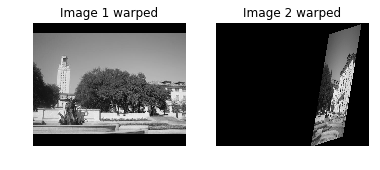

In [12]:
from utils import get_output_space, warp_image

# Extract matched keypoints
p1 = keypoints1[matches[:,0]]
p2 = keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

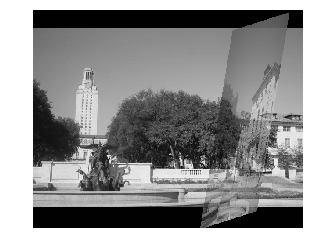

In [13]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

## Part 4 RANSAC (20 points)
Rather than directly feeding all our keypoint matches into ``fit_affine_matrix`` function, we can instead use RANSAC ("RANdom SAmple Consensus") to select only "inliers" to use to compute the transformation matrix.

Thay vì sử dụng toàn bộ các cặp keypoint khớp với nhau đưa vào hàm ``fit_affine_matrix``, ta có thể dùng kỹ thuật RANSAC ("RANdom SAmple Consensus") để chỉ chọn những "inliers" (tức các cặp keypoint) phù hợp để tìm ma trận biến đổi $H$.

The steps of RANSAC are:

Các bước của RANSAC bao gồm:

    1. Select random set of matches
    
    Chọn ngẫu nhiên một số cặp điểm (ví dụ: 4 cặp)
    
    2. Compute affine transformation matrix
    
    Tính ma trận biến đổi $H$ từ các cặp điểm đã chọn
    
    3. Find inliers using the given threshold
    
    Tìm các inliers với một ngưỡng cho trước. Một cặp điểm (x1, x2) được gọi là inliers nếu khoảng cách từ điểm x2H đến  x1 < ngưỡng
    
    4. Repeat and keep the largest set of inliers
    
    Lặp lại quá trình này (các bước từ 1 đến 3) sau một số lần và giữ lại tập inliers có nhiều phần tử nhất
    
    5. Re-compute least-squares estimate on all of the inliers
    
    Tính lại ma trận $H$ từ tập các inliers nhiều nhất.

Implement **`ransac`** in `panorama.py`, run through the following code to get a panorama. You can see the difference from the result we get without RANSAC.

Hãy cài đặt hàm **`ransac`** trong `panorama.py`, chạy lại đoạn code bên dưới để có được ảnh ghép panorama. Bạn sẽ thấy sự khác nhau giữa có và không sử dụng RANSAC.


[5.55754091e+01 3.21999662e+03 1.78975899e-26]
[3.00919042e+03 7.38899160e+04 2.71122865e-27]
[2.05854599e+03 7.30930180e+04 1.50131324e-27]
[1.42998324e+03 1.02944593e+05 4.08945493e-27]
[7.54459026e+02 8.55651556e+04 2.64230193e-27]
[1.14361867e+02 2.55394460e+04 8.33234331e-30]
[4.28706924e+01 1.34282241e+03 2.54057585e-27]
[9.25205897e+00 1.24245848e+04 5.17571640e-27]
[3.21969330e+01 1.50940464e+04 7.88860905e-29]
[5.17488402e+01 5.40315839e+04 3.68903407e-28]
[9.90455748e+00 3.38400542e+02 1.35861569e-27]
[3.57632614e+01 5.33014547e+04 3.27488209e-28]
[5.28041716e+00 2.43038370e+03 8.59069526e-28]
[3.74345802e-01 1.52527465e+03 2.86361439e-27]
[1.36034155e+02 7.68314088e+02 9.66354609e-28]
[1.49324089e+01 6.42114970e+02 2.63090042e-27]
[6.50551704e+00 5.85933688e+03 6.07472201e-28]
[2.23682811e+01 2.39415279e+02 1.68742278e-27]
[1.91962146e+01 3.46473012e+03 8.72135035e-28]
[1.31586508e+00 4.31149054e+04 8.49134809e-29]
[3.74697511e+00 1.64692570e+04 1.23259516e-28]
[4.67834080e+

[8.02255804e+00 1.37159896e+02 4.93038066e-32]
[2.67711886e-01 1.06008694e+02 1.10933565e-31]
[2.67711886e-01 2.80481704e+01 1.10933565e-31]
[2.67711886e-01 1.87798181e+02 1.10933565e-31]
[5.83892158e+00 8.02300401e+01 1.10933565e-31]
[7.77909222e+00 6.33855527e+01 1.10933565e-31]
[3.41048853e+00 6.43208356e+01 1.10933565e-31]
[3.70624587e+00 6.43120498e+01 1.10933565e-31]
[2.03372422e+00 7.22730432e+01 1.10933565e-31]
[5.90895034e+01 1.25226273e+05 4.93038066e-32]
[1.42801626e+03 9.36595608e+04 1.10933565e-31]
[3.61875247e-01 2.74837546e+02 1.10933565e-31]
[5.52239885e+01 8.75384740e+03 5.85778526e-28]
[2.77027810e+02 5.24120280e+04 2.60817137e-29]
[2.48574040e+02 4.45600964e+04 4.43734259e-31]
[3.56504596e+02 7.00222938e+04 4.43734259e-29]
[3.00617814e+02 4.84781199e+04 6.52042842e-30]
[2.21501199e+01 3.14547838e+03 1.23259516e-28]
[1.28805202e+02 2.49180528e+04 6.07472201e-28]
[3.53457153e+02 5.78875237e+04 9.11923206e-28]
[1.45811393e+00 1.20733889e+02 2.08308583e-28]
[1.07111396e+

[1.63420831e+01 1.13283569e+02 2.52758923e-26]
[3.42536982e+01 1.94765936e+00 1.19346766e-26]
[1.62334103e+00 2.69368188e+02 2.40210118e-26]
[9.55812306e+00 2.46109995e+03 8.82188081e-27]
[5.59459402e-01 2.63671125e+01 1.73376343e-26]
[1.74627949e+00 1.07555847e+03 1.11241714e-26]
[2.73011436e+01 1.74230171e+04 2.99964359e-28]
[1.67035975e+01 6.19392133e+03 4.06110524e-27]
[2.31398489e+00 1.31492408e+03 2.83281923e-26]
[1.31637553e+00 6.55586033e+02 1.19346766e-26]
[3.36152830e-01 6.69773110e+02 1.15020357e-26]
[7.90300868e+00 1.50216169e+04 4.08284822e-28]
[3.42171032e+01 1.00849641e+03 4.61034472e-26]
[1.48197501e+01 2.94960112e+04 5.48763693e-28]
[1.33601917e-01 7.97402437e+03 1.95248004e-27]
[9.51648787e-01 1.22540375e+04 7.21857032e-28]
[2.73901226e+00 1.59832967e+04 1.54616737e-28]
[6.14478101e+01 9.15565847e+03 3.74038891e-26]
[6.14478101e+01 8.22380642e+03 3.74038891e-26]
[6.14478101e+01 5.13876863e+03 3.74038891e-26]
[3.71849938e+00 5.88414855e+03 2.40804722e-27]
[4.49600030e+

[3.56904246e+03 5.16785027e+05 1.16928908e-27]
[8.09907567e+01 2.07811832e+03 2.11525656e-28]
[2.16822778e+01 4.87192992e+01 1.35893617e-28]
[9.66202106e+01 3.79006033e+03 3.11612384e-28]
[4.14717083e+01 2.82823310e+03 2.24640469e-28]
[2.84554791e+00 1.13865045e+02 1.50992908e-29]
[1.82664964e-01 1.34132313e+01 7.49910898e-29]
[1.17937489e-01 1.63931657e+02 1.89523832e-28]
[8.86645825e-01 3.26900738e+01 1.49144015e-30]
[1.68234537e+00 7.54815144e+01 6.21351222e-29]
[2.31163472e-01 4.60765004e-01 2.83989926e-29]
[1.59169727e+00 4.79691950e+01 5.86838558e-29]
[1.59871462e-02 1.40361560e-01 1.26217745e-29]
[4.11473071e-02 4.91833253e+01 8.69719148e-29]
[4.00492557e+01 5.25983797e+02 1.42488001e-29]
[6.72371628e-02 6.48868697e+01 7.49910898e-29]
[2.75875779e-02 5.86099216e+00 4.93038066e-30]
[5.25005114e-04 3.60530388e+01 3.86541844e-29]
[1.15977704e-01 1.01861051e+01 1.26217745e-29]
[1.27616928e-02 6.65926417e+00 3.20598002e-29]
[5.11134277e-01 1.71669315e-01 7.88860905e-31]
[2.06180748e-

[3.93878310e+00 3.77800539e+02 4.93038066e-32]
[7.59646145e-02 2.31987404e+03 4.93038066e-32]
[1.17972975e+02 1.44175635e+03 1.10933565e-31]
[8.00831239e-01 2.39723060e+02 4.93038066e-32]
[2.11320996e+01 4.80286490e+03 1.10933565e-31]
[8.34787522e+00 6.42394899e+02 1.10933565e-31]
[2.15371413e+01 3.82200901e+03 1.10933565e-31]
[8.03167108e+01 3.36016045e+04 1.10933565e-31]
[3.30177980e+01 1.40555334e+04 1.10933565e-31]
[1.44884873e+00 2.37410695e+02 4.93038066e-32]
[1.49114641e+01 4.22116155e+03 1.10933565e-31]
[2.71953769e+01 5.82776733e+03 1.10933565e-31]
[9.34806054e+01 4.02413232e+04 1.97215226e-31]
[5.72450098e-02 2.25257487e+01 4.93038066e-32]
[1.47069418e+02 7.38238161e+04 1.97215226e-31]
[9.17675530e+01 3.25647703e+04 1.10933565e-31]
[9.95507667e+01 4.16653646e+04 1.97215226e-31]
[1.09489857e+02 5.15995229e+04 1.97215226e-31]
[4.72907072e+00 5.70688074e+02 4.93038066e-32]
[4.72907072e+00 3.56797288e+02 4.93038066e-32]
[4.72907072e+00 1.23035681e-02 4.93038066e-32]
[8.54126529e+

[1.97719372e-01 6.78614572e+00 4.93038066e-32]
[1.97719372e-01 4.66777026e+02 4.93038066e-32]
[1.43497447e+00 2.62405845e+01 4.93038066e-32]
[3.24275466e+00 2.98807346e+01 4.93038066e-32]
[6.99839405e-01 3.12326916e+01 4.93038066e-32]
[7.85361862e-01 2.93834492e+01 4.93038066e-32]
[8.67764370e-01 1.12323719e+02 4.93038066e-32]
[3.58603154e+01 1.27223130e+05 4.93038066e-32]
[1.35429631e+03 9.51930272e+04 4.93038066e-32]
[5.47719262e-01 1.04250393e+03 4.93038066e-32]
[3.29707574e+03 2.00207175e+05 4.43734259e-31]
[7.72006471e+01 2.12491703e+04 4.93038066e-32]
[6.98850873e+01 3.43624282e+03 4.93038066e-32]
[1.06566913e+00 4.68184910e+01 1.97215226e-31]
[6.12584256e+00 2.75385483e+03 1.97215226e-31]
[2.97447581e+00 5.15883024e+03 1.97215226e-31]
[1.65962632e+01 3.65342454e+03 4.93038066e-32]
[2.55599623e+01 1.08337992e+04 4.93038066e-32]
[4.85583765e+00 5.62002311e+03 1.97215226e-31]
[2.66457610e+01 2.53316927e+04 1.97215226e-31]
[1.06777328e-01 5.85229531e+00 4.93038066e-32]
[3.09785514e+

[2.18976797e+01 1.32489958e+05 6.14369803e-27]
[1.30463764e+03 9.77227545e+04 9.66354609e-28]
[6.49807832e-01 2.43290725e+00 3.81039539e-27]
[2.93046093e+03 1.90384247e+05 4.43734259e-31]
[2.86594428e-03 1.31874318e+04 4.93038066e-32]
[5.46743518e+00 3.26230298e+03 4.93038066e-32]
[1.35138842e+01 8.08052871e+01 1.97215226e-31]
[5.01259101e+00 4.46516990e+02 1.97215226e-31]
[2.16623605e-04 4.58476350e+01 4.93038066e-32]
[4.34647676e+00 2.39666370e+04 0.00000000e+00]
[3.42949019e+00 4.27154385e+04 0.00000000e+00]
[9.39958492e-04 2.63076396e+02 4.93038066e-32]
[2.95168474e-01 5.37639405e+03 1.97215226e-31]
[2.81665439e-01 9.29772913e+03 4.93038066e-32]
[4.69722462e-01 5.93856592e+03 1.97215226e-31]
[5.91805784e-01 4.01278772e+03 4.93038066e-32]
[2.24570690e-01 1.70958176e+04 0.00000000e+00]
[4.68862502e+01 3.06332019e+03 4.93038066e-32]
[9.37457774e-02 1.07674198e+04 0.00000000e+00]
[1.12864066e-01 4.33592421e+02 4.93038066e-32]
[6.71970491e-02 4.28457762e+03 4.93038066e-32]
[4.65885799e-

[2.18484643e+02 3.32607207e+04 9.32951280e-27]
[3.38170318e+00 1.27804632e+02 5.17998118e-26]
[1.98361413e+01 3.10934811e+03 1.27959205e-25]
[1.32336324e+02 1.93179154e+04 7.51993984e-28]
[3.55475259e+02 5.34967110e+04 3.95818848e-26]
[1.69363814e+01 2.36694627e+03 2.03846095e-26]
[3.38164046e+02 5.16197416e+04 3.70611291e-26]
[4.16987810e+01 4.84367690e+03 9.24392139e-27]
[4.23381388e-01 4.30165206e+01 5.91164967e-26]
[2.70104381e+00 8.27171322e+02 1.05236017e-26]
[4.61954951e-02 2.26548405e+01 5.20021546e-26]
[4.50056289e+01 6.47769757e+03 4.11790323e-27]
[4.58780283e+00 6.85247806e+02 2.69258442e-26]
[2.46370970e+01 3.86983074e+03 8.78021909e-27]
[2.51859324e+02 3.54767140e+04 2.02264059e-26]
[1.22350293e+02 1.46159145e+04 3.15544362e-28]
[5.21000743e+00 6.13853531e+02 6.83019931e-26]
[2.86922501e+01 3.10924298e+03 1.05236017e-26]
[2.11870616e+01 3.41462723e+03 9.24392139e-27]
[2.35565915e+02 3.33827219e+04 1.90441993e-26]
[6.70202451e+01 8.88924784e+02 1.46199789e-25]
[4.28167644e+

[2.06646985e-01 6.18486906e+00 8.33234331e-30]
[2.12388846e-04 2.77867891e-02 5.36918454e-29]
[4.16065298e+01 7.98487744e+02 8.33234331e-30]
[4.97320206e-02 6.47249185e-03 4.43734259e-29]
[1.31707179e-02 5.45726826e-01 3.15544362e-30]
[1.01536764e-02 3.63660105e-01 2.17429787e-29]
[1.48715794e-01 1.91015866e+00 7.09974815e-30]
[2.94380481e-06 1.84446155e-04 2.17429787e-29]
[5.50396226e-01 2.64161704e+00 7.88860905e-31]
[3.72007961e-03 2.26092542e+00 6.03971631e-29]
[3.02156481e-01 1.58137022e+00 8.33234331e-30]
[1.29844685e-01 9.42690450e-02 7.09974815e-30]
[2.89625344e-04 1.19845518e+00 2.17429787e-29]
[4.89876455e-02 4.21372364e+03 1.28239201e-28]
[5.49972316e-02 2.30593216e+01 6.93334780e-29]
[3.24574278e-01 2.79591498e-02 7.70371978e-30]
[1.11872048e-02 1.71764636e+00 1.77986742e-29]
[9.00375543e-02 3.53320031e+00 2.95946099e-29]
[2.90540634e-01 2.16075260e+02 8.69719148e-29]
[2.90540634e-01 9.40802734e+01 8.69719148e-29]
[2.90540634e-01 8.64993260e+01 8.69719148e-29]
[1.57982818e-

[4.51856372e+01 4.28043894e+03 3.43758465e-26]
[1.70142392e+01 3.59436946e+03 3.61557830e-25]
[4.65592143e+00 1.08546080e+02 1.33904405e-25]
[2.05131942e+00 2.10489441e+02 1.27959205e-25]
[1.03590794e+02 1.53337902e+04 1.04326855e-28]
[7.66062414e+01 2.69924890e+03 6.16111460e-25]
[2.12532782e+02 3.31501030e+04 2.68530224e-26]
[5.27628191e+01 8.84714783e+03 1.11710593e-26]
[8.83951263e+01 1.36635160e+04 1.32607518e-27]
[1.25485943e+02 1.83977706e+04 4.73513758e-28]
[4.94004126e+01 1.06436453e+04 4.87665183e-25]
[4.94004126e+01 9.63696487e+03 4.87665183e-25]
[4.94004126e+01 6.26757920e+03 4.87665183e-25]
[6.02517224e+01 8.13790701e+03 1.51868050e-26]
[4.70828577e+01 4.99753196e+03 3.41292782e-26]
[3.59872468e+01 5.21834005e+03 3.26685050e-26]
[3.88939330e+01 5.55810798e+03 2.99195713e-26]
[5.73777145e+00 8.43643558e+02 1.10342708e-25]
[2.20920254e+02 5.73222226e+04 8.07793567e-28]
[1.75240150e+03 5.91981871e+04 3.41292782e-26]
[1.66314000e+01 7.82455718e+02 3.47020356e-25]
[3.51449439e+

[1.86307111e+00 1.99057723e+04 8.60371639e-26]
[6.95468901e-01 2.35613840e+04 1.84127839e-25]
[2.02623800e-01 2.78246169e+04 2.96550379e-25]
[3.64011339e+00 1.09097738e+03 7.54918636e-25]
[3.64011339e+00 1.44627685e+03 7.54918636e-25]
[3.64011339e+00 3.25241483e+03 7.54918636e-25]
[6.49432824e-01 2.44527395e+04 7.12343370e-26]
[7.72118820e-02 2.13513325e+04 2.13467733e-26]
[1.70839744e+00 2.26005303e+04 2.43317367e-26]
[1.55764689e+00 2.29496210e+04 2.92702032e-26]
[3.82804063e+00 2.44255125e+04 1.63578197e-26]
[7.28403342e+00 1.47904209e+04 2.35926418e-25]
[1.20562629e+03 2.81833749e+04 2.13467733e-26]
[3.72430556e+01 9.56493780e+04 2.98124390e-25]
[1.88258823e+00 2.79746702e+02 3.31114627e-26]
[2.33365558e+03 3.95604624e+05 4.34903947e-27]
[1.67909949e+03 2.81544616e+05 2.07199247e-27]
[1.36884346e+03 2.44546239e+05 6.62259823e-27]
[8.33969020e+02 1.35416466e+05 3.86541844e-27]
[1.49518865e+02 2.39822302e+04 8.69719148e-29]
[1.25401918e+01 1.20851657e+03 7.46070131e-27]
[2.40723813e+

[1.17671619e-03 8.85263106e-01 1.34799676e-25]
[8.57991938e-05 1.16626476e+00 1.44084964e-25]
[2.33834901e-02 8.37570310e-02 1.93827562e-26]
[2.43294425e+01 1.37096893e+05 4.27613147e-25]
[1.29143893e+03 9.90219361e+04 1.28356655e-25]
[1.73164258e-04 2.12527753e-02 2.75119678e-26]
[1.59212170e+01 4.84782271e+03 7.56262338e-26]
[1.92362987e+03 2.15367250e+04 8.53231955e-27]
[1.39888946e+03 2.26458871e+04 3.35862461e-27]
[1.14913771e+03 5.46629290e+04 1.31274343e-26]
[7.10568384e+02 4.47393135e+04 6.73146104e-27]
[1.21831504e+02 2.99666405e+03 1.19985744e-27]
[4.78120629e+00 3.77454414e+04 2.49241096e-26]
[8.44039296e+00 8.34784100e+04 4.31948677e-26]
[4.20611543e+01 1.63161694e+02 3.97664782e-27]
[1.20403075e+02 2.31646441e+04 2.08308583e-30]
[1.93069144e+00 1.43285908e+04 1.63010710e-26]
[1.00835781e+02 2.28534291e+04 2.41588652e-30]
[4.00026552e+00 6.07410551e+03 1.23259516e-26]
[9.78604872e+00 3.62840130e+04 2.78073962e-26]
[9.21761369e+01 8.13817642e+03 1.36930969e-26]
[2.33121347e+

[8.32441907e+03 4.22808786e+05 1.51868050e-28]
[5.69870697e+03 2.37807742e+05 9.98402083e-29]
[3.99014782e+03 2.46063632e+05 2.21324788e-28]
[2.16182061e+03 1.32361494e+05 1.63010710e-28]
[5.61014916e+02 2.35075622e+04 1.42488001e-29]
[5.31101570e+02 1.57669459e+04 4.14645013e-29]
[4.17282913e+02 1.04370424e+04 1.13595970e-28]
[2.85075415e+02 1.04587326e+04 2.41588652e-30]
[2.47308977e+02 9.66250603e+03 4.89217021e-29]
[2.67920168e+02 8.41634618e+03 1.42488001e-29]
[1.94258798e+02 7.27214649e+03 4.58648661e-29]
[1.86821155e+02 5.14309920e+03 4.93038066e-30]
[1.56135589e+02 3.69177877e+03 4.73809581e-29]
[1.97280829e+01 4.81174264e+02 5.96576060e-30]
[4.60879839e+01 4.50222317e+02 4.14645013e-29]
[3.04299804e+01 3.89058910e+02 1.77493704e-30]
[1.75783238e+01 6.66572936e+01 1.97215226e-29]
[1.14573727e+01 5.08583825e+01 4.93038066e-30]
[1.01108358e+01 5.66709205e+01 2.72280272e-29]
[1.75310903e+01 6.23013052e+01 1.77493704e-30]
[8.45114075e+00 2.72602678e+01 5.69952004e-29]
[6.54525371e+

[5.70054488e-01 8.92543381e+03 3.33293732e-29]
[4.07923520e+02 5.50194784e+04 1.21528953e-27]
[1.51224000e-02 9.28918756e+03 4.14645013e-29]
[2.92492862e+02 3.15767729e+04 9.80208979e-28]
[7.23859282e+02 9.80513961e+04 1.91343143e-27]
[6.58040792e+02 2.73892541e+04 1.07995058e-27]
[6.95317023e+02 7.57648920e+04 1.85559806e-27]
[2.72021966e+02 1.33109760e+04 8.59069526e-28]
[5.25135218e+02 4.23037812e+04 1.42488001e-27]
[3.54597031e+02 1.87715610e+04 1.02236373e-27]
[1.33124410e+01 8.62881706e+03 1.38494393e-28]
[1.14778344e+02 8.43488054e+02 5.02948131e-28]
[8.49667528e+02 8.50252501e+04 2.13307989e-27]
[3.47908511e+02 1.91814166e+04 1.07995058e-27]
[3.73911441e+02 1.55309576e+04 1.05095994e-27]
[1.91487775e+01 1.14334368e+04 1.60188068e-28]
[1.39671671e+03 1.07786587e+05 3.25646712e-27]
[9.34442836e+00 5.37161551e+04 7.09974815e-30]
[8.48058034e+01 3.27391085e+03 3.31518795e-28]
[3.36142797e+01 1.04657443e+04 2.01948392e-28]
[8.92127201e+00 2.05202636e+04 1.18378440e-28]
[1.18294214e+

[2.80448053e-01 1.38234425e+02 4.67715631e-27]
[1.36380789e+00 4.22376927e+01 1.05672651e-25]
[1.08731864e-01 1.82615142e+02 2.07028656e-26]
[1.10845721e+00 6.15155501e+03 2.15673203e-25]
[3.82690620e-01 1.89755907e+03 2.06390172e-26]
[3.29061313e+00 4.92428909e+02 3.30734865e-25]
[1.42418585e+00 4.32106322e+02 2.75856770e-26]
[1.09509575e-02 1.05293128e+03 2.20664610e-26]
[1.79070722e+00 1.03162092e+04 2.07098187e-25]
[4.94582399e+00 1.00929011e+03 7.83741642e-25]
[4.57123243e+00 2.13972359e+04 5.77689201e-25]
[2.86779605e+00 9.95011837e+03 8.72790898e-26]
[2.40447327e+00 1.25248633e+04 1.72133998e-25]
[2.20203855e+00 1.59140585e+04 2.66861894e-25]
[1.17643324e+00 3.85712204e+01 5.27845764e-25]
[1.17643324e+00 1.46548765e+00 5.27845764e-25]
[1.17643324e+00 3.16463703e+02 5.27845764e-25]
[9.89360283e-01 1.45824487e+04 7.44704909e-26]
[1.47907933e-02 1.22595641e+04 2.77703814e-26]
[1.35953335e+00 1.34684807e+04 3.07705057e-26]
[1.32277912e+00 1.37318896e+04 3.56220003e-26]
[8.13293369e-

[4.92260245e+01 1.17550246e+04 3.36377390e-25]
[1.55098762e+02 2.78322317e+04 5.52321407e-25]
[4.18362819e-01 6.50811646e+00 7.41073684e-26]
[4.53076379e+01 6.98020534e+03 3.86541844e-27]
[3.07481506e+01 5.85592416e+03 2.33023398e-25]
[3.90763656e+01 6.38723281e+03 5.23981135e-27]
[1.33248066e+01 3.43055417e+03 1.84604545e-25]
[9.45785109e+01 1.56248595e+04 3.73945510e-25]
[1.46279465e+02 9.73764374e+03 2.04178156e-25]
[9.22629456e+01 1.53865853e+04 3.60490501e-25]
[1.51588340e+01 2.45966620e+03 1.59921876e-25]
[6.06517383e+01 9.46137696e+03 2.75068106e-25]
[3.01455818e+01 4.33873649e+03 1.92510460e-25]
[1.36662014e+01 1.99820997e+03 2.21324788e-26]
[4.29144360e-02 2.11448317e+02 9.10582636e-26]
[1.33594081e+02 2.00962495e+04 4.17222666e-25]
[2.59549980e+01 5.13795074e+03 2.04178156e-25]
[3.54500107e+01 4.81527421e+03 1.98994157e-25]
[9.33521082e+00 1.55677595e+03 2.54881452e-26]
[2.79936279e+02 1.92377784e+04 6.40042739e-25]
[5.59401169e+01 9.22966526e+03 2.84778787e-28]
[4.37136516e-

[8.07782650e+03 1.42067030e+05 1.77493704e-30]
[1.89921184e+02 7.46454741e+03 1.97215226e-31]
[8.89331558e+01 1.12716765e+04 1.97215226e-31]
[4.88861077e+02 1.32637935e+04 4.43734259e-31]
[3.57985192e+02 1.13820103e+04 7.88860905e-31]
[4.34408316e+01 2.76050156e+03 4.43734259e-31]
[7.12797268e+01 3.20605736e+03 4.93038066e-32]
[ 177.55742141 9279.71291646    0.        ]
[1.72482065e+01 1.19736867e+03 4.43734259e-31]
[1.36700892e+02 9.62713427e+03 7.88860905e-31]
[9.99446017e+00 5.78974677e+02 1.97215226e-31]
[1.36297912e+02 9.67210616e+03 7.88860905e-31]
[1.80599137e+00 3.03461594e+01 1.97215226e-31]
[4.80757130e+01 2.94960285e+03 4.93038066e-32]
[4.39712926e+01 6.11362908e+02 4.43734259e-31]
[3.39474880e+01 1.96605966e+03 1.97215226e-31]
[2.16326531e+00 1.83698507e+02 4.43734259e-31]
[6.54039521e+00 4.24201693e+02 1.97215226e-31]
[5.31228225e-01 1.53589626e+01 1.97215226e-31]
[1.05693636e+02 7.97034079e+03 7.88860905e-31]
[1.85200331e+01 1.88474339e+03 4.43734259e-31]
[4.23165978e+01 

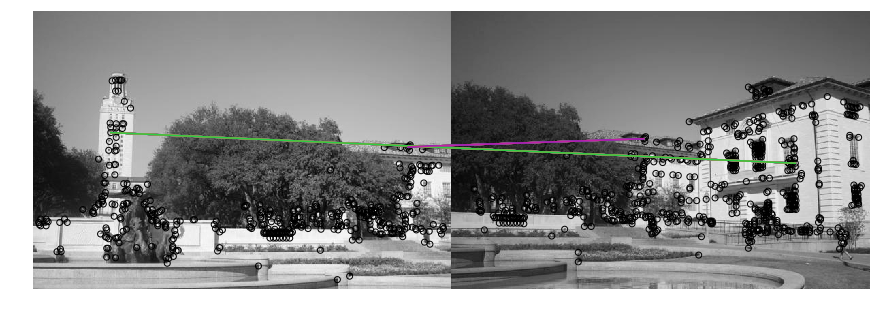

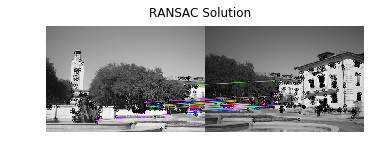

In [14]:
from panorama import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Visualize robust matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac.png'))
plt.axis('off')
plt.title('RANSAC Solution')
plt.show()

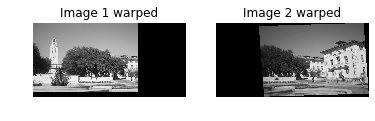

In [15]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

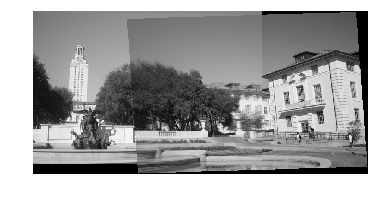

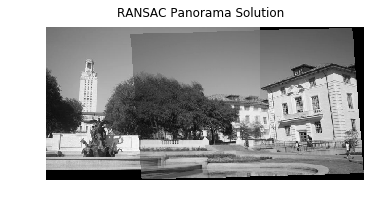

In [16]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_ransac_panorama.png'))
plt.axis('off')
plt.title('RANSAC Panorama Solution')
plt.show()

## Part 5 Histogram of Oriented Gradients (HOG) (20 points)
In the above code, you are using the `simple_descriptor`, and in this section, you are going to implement a simplified version of HOG descriptor. <br>
HOG stands for Histogram of	Oriented Gradients. In HOG descriptor, the distribution ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.<br>
The steps of HOG are:

Trong phần code bên trên, bạn đang sử dụng `simple_descriptor`, và trong phần này, bạn sẽ cài đặt một phiên bản đơn giản hoá của bộ mô tả HOG. <br>
HOG là từ viết tắt của Histogram of	Oriented Gradients (Lược đồ phân bố gradient có hướng). Trong bộ mô tả HOG, phân phối của gradient (có hướng) được dùng như đặc trưng. Gradients (đạo hàm riêng theo x và y) của ảnh là một đặc trưng quan trọng vì độ lớn của gradient sẽ lơn tại các đường biên và góc (vùng có sự thay đổi đột về cường độ sáng) và ta cũng biết rằng cung và góc chứa rất nhiều thông tin về hình dáng của đối tượng hơn là các vùng không có thay độ sáng.<br>
Các bước của giải thuật tính bộ mô tả HOG bao gồm:

    1. compute the gradient image in x and y
        Use the Sobel filter provided by skimage.filters
        
    Tính đạo hàm ảnh theo x và y
        Sử dụng bộ lọc Sobel trong module skimage.filters
        
    2. compute gradient histograms
        Divide image into cells, and calculate histogram of gradient in each cell.
        
    Tính lược đồ phân bố gradient
        Chia ảnh thành các ô, và tính lược đồ phân bố gradient trong mỗi ô.
        
    3. normalize across block
        Normalize the histogram so that they
        
    Chuẩn hoá các khối
        Chuẩn hoá lược đồ phân bố sao cho chúng đều nhau
        
    4. flattening block into a feature vector
    
    Trải rộng các khối thành một vector đặc trưng duy nhất

Implement **`hog_descriptor`** in `panorama.py`, and run through the following code to get a panorama image.

Hãy cài đặt hàm **`hog_descriptor`** trong `panorama.py`, và chạy đoạn code bên dưới để có ảnh panorama.

In [17]:
from panorama import hog_descriptor

img1 = imread('uttower1.jpg', as_grey=True)
img2 = imread('uttower2.jpg', as_grey=True)

# Detect keypoints in both images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)


In [18]:
# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=hog_descriptor,
                           patch_size=16)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=hog_descriptor,
                           patch_size=16)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
plt.imshow(imread('solution_hog.png'))
plt.axis('off')
plt.title('HOG descriptor Solution')
plt.show()

8


IndexError: tuple index out of range

[3.81786091e+00 2.45762166e+03 1.02805142e-25]
[3.20836207e+03 3.58793293e+04 1.39279433e-26]
[2.19982243e+03 4.27945558e+04 6.87799195e-27]
[1.63742888e+03 7.97811490e+04 2.11848719e-26]
[8.93772843e+02 7.48136232e+04 1.26485095e-26]
[1.33484074e+02 2.19841519e+04 1.28239201e-28]
[2.79933798e+01 5.95672129e+03 2.11525656e-26]
[9.07992736e-01 2.61650304e+04 3.98473858e-26]
[3.80152495e+01 1.30627979e+04 1.72410481e-27]
[7.80080738e+01 5.86626037e+04 8.39656152e-28]
[6.36075705e+00 3.60954220e+01 1.24743068e-26]
[5.77396544e+01 5.87535852e+04 6.74919808e-28]
[4.08706417e+00 1.15205802e+03 8.69719148e-27]
[3.43126131e+00 4.63629003e+03 2.36781038e-26]
[1.40235260e+02 7.32499190e+02 9.67582274e-27]
[2.43042433e+01 2.00016676e+03 2.21985952e-26]
[6.34986246e+00 5.58981532e+03 6.67691870e-27]
[2.85504342e+01 3.10755088e+01 1.51868050e-26]
[2.04578121e+01 3.21313921e+03 8.90550006e-27]
[7.91082438e-02 5.28012393e+04 7.70371978e-30]
[1.78131013e+00 1.89656748e+04 2.34311410e-27]
[6.53044826e+

[9.86081564e+01 7.43629410e+03 1.10933565e-27]
[1.45017586e+02 9.58206987e+03 1.42488001e-27]
[3.46773879e+02 2.95267429e+04 3.09265029e-26]
[2.83866033e+01 8.28774811e+03 1.68729952e-26]
[5.15088527e+02 4.79024758e+04 6.05285084e-26]
[3.74543905e+02 2.83743268e+04 1.96931236e-26]
[3.98220970e+02 3.29828569e+04 2.80671903e-26]
[4.40162082e+02 3.86605201e+04 3.64227064e-26]
[1.04035957e+02 2.90777932e+03 8.53231955e-27]
[1.04035957e+02 3.47201761e+03 8.53231955e-27]
[1.04035957e+02 6.07212310e+03 8.53231955e-27]
[4.32594519e+02 3.56753752e+04 1.85873379e-26]
[3.71082249e+02 3.16679093e+04 1.25986140e-26]
[4.33454730e+02 3.35922345e+04 1.31020059e-26]
[4.36245969e+02 3.40485171e+04 1.37972265e-26]
[5.13565545e+02 3.84649529e+04 3.58094780e-27]
[7.85171080e+02 4.45141472e+03 3.44582332e-26]
[2.47637582e+02 1.85082977e+04 1.25986140e-26]
[2.15873510e+03 1.61473021e+05 9.54521695e-29]
[2.47668979e+03 4.11574138e+05 2.21456942e-24]
[5.71029227e+00 5.00227222e+02 4.46400658e-25]
[1.97790092e+

[3.63592197e+00 2.80470882e+01 3.34761014e-26]
[1.78856587e-01 9.99746964e+01 6.47704119e-25]
[4.47641998e+00 1.98812308e+01 1.83651749e-27]
[3.76971711e+00 3.24102121e+01 2.24737844e-25]
[2.98869807e+01 5.76487811e+02 2.56300908e-27]
[3.15698441e+00 1.87820989e+01 1.79488733e-25]
[1.00790263e+00 2.20091051e+01 3.46235982e-27]
[1.35779763e+00 1.33940016e+01 5.44610340e-26]
[4.70766018e-01 1.12697517e+01 6.86506203e-28]
[2.40165441e-01 4.35543743e+01 4.46549026e-25]
[2.36112804e+00 1.59087671e+01 9.12593861e-26]
[1.81480660e+00 2.13820136e+01 2.68355146e-25]
[2.35039980e+00 8.93913982e+00 2.56300908e-27]
[2.53690155e-01 1.29454991e+01 8.85299151e-28]
[6.33568494e-02 4.42597910e+01 4.35489874e-25]
[1.48137393e+00 4.36312827e+03 7.56849127e-25]
[5.29335979e-03 1.18646202e+02 1.01824589e-24]
[1.36322693e-01 1.74728003e+01 2.29818897e-25]
[2.47878082e-06 3.72844916e+01 3.78986343e-25]
[7.57663899e-02 4.69589899e+01 5.35780140e-25]
[2.10164525e-01 2.01279793e+02 4.70757676e-25]
[2.10164525e-

[5.15494113e-03 2.04637857e+01 5.53977571e-28]
[3.96318154e-01 4.50400302e+00 2.48540489e-28]
[1.02540921e+00 1.71015822e+00 1.04326855e-28]
[1.67527669e-02 1.72410922e-01 1.26217745e-29]
[7.02661519e-03 5.98689990e+01 1.16928908e-27]
[1.14287992e-02 2.06676279e+00 2.84778787e-28]
[1.07720389e+00 1.76082812e+00 2.55590933e-28]
[2.34995095e+00 6.33204449e+00 9.32951280e-29]
[5.52553261e-02 5.07063279e+03 2.25791713e-27]
[3.68169497e+00 4.68508195e+00 5.07940141e-28]
[5.31018315e+00 1.75916830e+01 7.09974815e-30]
[3.79503118e+00 1.20569447e+01 6.03971631e-29]
[3.03929397e+00 1.61740254e+01 1.46444631e-28]
[1.82986097e+00 1.50299505e+02 1.68742278e-27]
[1.82986097e+00 5.27028067e+01 1.68742278e-27]
[1.82986097e+00 1.37835351e+02 1.68742278e-27]
[3.47562329e+00 3.91983904e+01 2.41588652e-30]
[1.39479175e+00 3.75132013e+01 8.33234331e-30]
[5.07784745e+00 4.46241789e+01 7.09974815e-30]
[4.90099515e+00 4.65416024e+01 3.99360833e-30]
[7.74341656e+00 5.95150881e+01 1.83459464e-28]
[5.58280869e-

[2.47487886e-01 4.06009040e+03 1.46444631e-26]
[3.06648047e-02 9.43049582e+00 1.80762669e-26]
[4.39722897e-01 3.20146920e+00 3.89307787e-27]
[3.62629768e-02 1.15263909e-01 6.55051607e-27]
[5.70730931e-02 3.26278189e-02 9.35097228e-27]
[5.00162226e-01 2.58619553e+02 9.20127360e-27]
[5.00162226e-01 1.22803026e+02 9.20127360e-27]
[5.00162226e-01 6.27002241e+01 9.20127360e-27]
[1.46452211e-01 3.03828101e+00 3.50166728e-27]
[9.26452361e-01 5.08035360e+00 1.82701418e-27]
[5.85938355e-04 5.31700007e+00 1.94268091e-27]
[5.88703458e-03 5.60268868e+00 2.13307989e-27]
[6.61330407e-02 1.57186262e+00 3.59424750e-29]
[3.24343489e+01 1.34595604e+05 8.18720523e-27]
[1.29330313e+03 1.00016570e+05 1.82701418e-27]
[1.52425229e+00 2.31123794e+01 2.21591028e-27]
[7.14554510e+03 1.01103647e+05 1.20953129e-24]
[9.05157531e+01 4.61509844e+03 1.94855743e-25]
[5.97214272e+01 9.57181799e+00 1.13462308e-25]
[9.61073511e+01 4.31033505e+03 2.91253868e-25]
[1.64230360e+02 1.06881816e+04 1.95346131e-25]
[3.86421665e+

[7.62154144e-02 4.19918577e+02 5.93326446e-26]
[4.69894940e-02 6.51822311e-01 2.49600521e-27]
[7.16073624e-01 1.46447325e-02 3.52041505e-28]
[1.49394265e-02 1.19341198e-01 4.49663042e-28]
[5.76187844e-03 3.09414528e-01 6.29560306e-28]
[3.45550862e-04 8.51484611e+00 2.76934551e-27]
[2.41816571e+01 1.36613322e+05 1.11007644e-26]
[1.28495087e+03 9.86720123e+04 3.52041505e-28]
[3.56741495e-02 8.48378381e+01 2.69258442e-26]
[2.10062453e+03 3.96377583e+06 8.00738192e-27]
[4.68472824e+01 1.96603115e+06 1.63313929e-27]
[6.33612910e+01 1.17237685e+06 1.14662165e-27]
[6.03778163e+00 1.28478823e+06 2.38630424e-27]
[7.00503981e+00 7.18070114e+05 1.82701418e-27]
[4.60933799e+00 1.04275359e+05 2.66351489e-28]
[5.80885439e+00 1.09959482e+04 2.08308583e-28]
[1.89800756e+00 1.02585019e+01 7.09974815e-28]
[2.23680830e+00 3.64365232e+04 9.76338630e-29]
[3.22023126e+00 7.53599562e+04 6.86506203e-28]
[1.10723967e+00 6.91920479e+03 3.86541844e-29]
[2.36852572e+00 6.12607347e+04 6.57725106e-28]
[1.93968194e+

[ 0.42437106 16.84055597  0.        ]
[1.35683444e-01 1.19915283e+00 4.93038066e-32]
[2.28077172e-02 1.95162101e-01 4.93038066e-32]
[3.59969288e-01 9.35709949e-01 4.93038066e-32]
[6.59166010e-01 2.60253717e+02 4.43734259e-31]
[6.59166010e-01 1.23929907e+02 4.43734259e-31]
[6.59166010e-01 6.18994287e+01 4.43734259e-31]
[3.22711515e-01 1.98465358e+00 4.93038066e-32]
[1.22414473e+00 3.98829096e+00 4.93038066e-32]
[2.29234442e-02 4.45749365e+00 4.93038066e-32]
[4.37283254e-02 4.67744895e+00 4.93038066e-32]
[1.59666754e-02 3.20343628e+00 1.97215226e-31]
[3.08527221e+01 1.35254858e+05 4.93038066e-32]
[1.30367290e+03 9.98541486e+04 4.93038066e-32]
[6.88965783e-03 1.90453625e-01 1.97215226e-31]
[3.31796459e+03 2.62673482e+05 4.93038066e-32]
[3.68107854e+00 9.69664705e+03 4.93038066e-32]
[8.96327822e-01 1.28151665e+03 4.93038066e-32]
[3.11128326e+01 2.38531890e+02 4.93038066e-32]
[1.35906124e+01 3.53621250e+02 1.23259516e-32]
[1.65973813e-02 7.53879018e+02 1.23259516e-32]
[1.02611755e+01 4.7739

[6.33969022e+00 7.20254108e+02 9.71955521e-27]
[7.52221800e+01 7.02396303e+03 7.21857032e-28]
[1.37545184e+02 1.94194214e+04 2.72280272e-29]
[2.41993488e+01 5.63616892e+02 3.46235982e-27]
[1.15939812e+02 1.69376380e+04 1.42488001e-29]
[2.50353118e+01 5.71557916e+02 2.54057585e-27]
[1.06987731e+00 6.81544177e+02 6.10893885e-27]
[4.98769153e+01 3.17739717e+03 2.83989926e-27]
[1.13011606e+00 2.38733851e+03 5.80054354e-27]
[2.99389920e+00 9.98337904e-01 2.07199247e-27]
[1.03861536e+00 1.49513020e+03 4.14645013e-27]
[2.17551052e-04 3.33592905e+02 2.63090042e-27]
[2.72443245e+01 3.55864646e+03 5.04870979e-29]
[1.14547283e+01 3.04763989e+02 9.25383146e-28]
[1.35524096e+01 5.69089470e+03 6.85958931e-27]
[3.88865075e-03 8.62503259e+02 2.83989926e-27]
[2.51824138e+00 1.16297538e+03 2.72280272e-27]
[1.03094700e+01 1.53346876e+03 7.11946967e-29]
[6.82891230e+01 5.10436680e+03 1.12180458e-26]
[2.58626325e+01 5.35056076e+03 1.77493704e-28]
[2.88033124e-04 1.22440522e+01 4.26428623e-28]
[2.40946012e+

[1.29900744e+03 1.05350002e+05 1.51868050e-28]
[4.56939880e+00 4.52763505e+03 1.23259516e-28]
[3.18452364e+03 2.43497303e+05 1.97215226e-31]
[5.32126011e+00 1.66040535e+02 4.93038066e-32]
[5.77373758e-02 1.13719235e+03 4.93038066e-32]
[3.89794663e+01 1.26680340e+03 4.93038066e-32]
[2.62903178e+01 2.85655306e+03 4.93038066e-32]
[  12.09306444 2800.87762662    0.        ]
[2.69333656e+00 5.69568750e+02 1.23259516e-32]
[3.99644899e+00 2.41678177e+03 1.23259516e-32]
[  12.83722386 2383.37537748    0.        ]
[1.63888141e+01 9.49659765e+03 4.93038066e-32]
[10.33374035 44.65174596  0.        ]
[1.78049206e+01 1.00147312e+04 4.93038066e-32]
[  8.93139531 588.75714987   0.        ]
[1.15446709e+01 1.05342188e+02 1.23259516e-32]
[115.95178267 296.84702273   0.        ]
[1.32403996e+01 1.98485505e+01 1.23259516e-32]
[  17.45825194 2324.77701697    0.        ]
[ 17.56491733 607.81275562   0.        ]
[  20.90401083 1868.7815103     0.        ]
[1.95312968e+01 1.15438916e+04 4.93038066e-32]
[  12

[3.52933277e+01 3.23649058e+03 1.23259516e-32]
[2.31446757e+01 2.24841440e+03 1.23259516e-32]
[  24.08760871 1147.30871116    0.        ]
[  23.848454  1738.1879244    0.       ]
[  36.79105074 1985.26455641    0.        ]
[4.30283384e+01 3.79566159e+03 1.23259516e-32]
[  28.46668725 8736.94924296    0.        ]
[4.86345406e+01 5.52896087e+03 1.23259516e-32]
[5.48382801e+01 3.49344788e+03 1.23259516e-32]
[4.95222209e+01 3.99768297e+03 1.23259516e-32]
[4.68123065e+01 4.46356454e+03 1.23259516e-32]
[ 42.96089606 481.88619748   0.        ]
[ 42.96089606 726.40526214   0.        ]
[  42.96089606 2111.57770783    0.        ]
[4.99137415e+01 3.91730971e+03 1.23259516e-32]
[4.08596093e+01 3.56436919e+03 1.23259516e-32]
[5.59981260e+01 3.67656704e+03 1.23259516e-32]
[5.53876993e+01 3.70521305e+03 1.23259516e-32]
[  67.12603357 3898.17641684    0.        ]
[2.32745102e+01 7.97557911e+04 1.23259516e-32]
[8.18408958e+02 6.46673008e+04 1.23259516e-32]
[  208.57823452 10285.82510702     0.        ]

[1.25864063e+00 2.23068692e+03 4.93038066e-32]
[1.25864063e+00 7.96941279e+02 4.93038066e-32]
[2.93464166e-01 9.83294924e+03 0.00000000e+00]
[8.78342242e-02 7.29259411e+03 0.00000000e+00]
[5.29677529e-01 7.90299432e+03 0.00000000e+00]
[5.00628342e-01 8.18922823e+03 0.00000000e+00]
[1.65467779e-01 6.18141311e+03 0.00000000e+00]
[9.03289193e+00 3.70190744e+04 0.00000000e+00]
[ 1245.83362171 52259.47483503     0.        ]
[3.63915390e+00 2.80910200e+04 4.93038066e-32]
[2.37194604e+03 4.08972778e+05 2.19412988e-24]
[3.12922215e+00 8.12775913e+02 2.85055887e-25]
[1.50733380e+01 2.64740532e+03 1.34310977e-25]
[1.08705142e+00 1.51591372e-01 4.35050392e-25]
[2.23767147e-02 5.50081358e+01 2.52047025e-25]
[6.31450112e-01 2.73481108e+01 6.89641925e-27]
[6.58860549e-01 9.68559687e+00 5.07714872e-25]
[5.86093564e-02 2.28496501e+01 9.35097228e-25]
[2.19097166e-01 5.89820215e+00 5.06939767e-26]
[1.04003107e+00 4.60527653e+01 1.11241714e-26]
[1.68784331e-02 2.26094170e-01 3.08395359e-25]
[7.31836164e-

[1.43270742e+03 1.49523577e+05 8.00738192e-27]
[3.26408466e+03 4.31974155e+05 1.23259516e-30]
[2.52905422e+01 3.04711065e+01 1.97215226e-31]
[2.35635791e+00 1.13012341e+03 4.43734259e-31]
[4.96627613e+01 2.90996473e+02 4.43734259e-31]
[2.03074688e+01 3.59426262e+02 7.88860905e-31]
[7.76430228e-01 2.04500064e+00 4.43734259e-31]
[1.39267897e+00 1.36249937e+00 1.97215226e-31]
[1.02701224e+00 1.54176098e+01 1.97215226e-31]
[1.99412865e-01 5.11319246e-01 4.43734259e-31]
[7.58949256e-01 2.15306870e+01 7.88860905e-31]
[4.39295702e-05 1.43227861e-01 1.97215226e-31]
[8.33427261e-01 2.98924296e+01 7.88860905e-31]
[2.13609234e-01 4.77901830e-01 4.43734259e-31]
[1.59498651e-02 5.19511179e-02 1.97215226e-31]
[4.21560946e+01 7.72554040e+02 4.43734259e-31]
[1.02409216e-01 1.26769146e-01 1.97215226e-31]
[3.05954853e-02 3.18946801e-01 4.43734259e-31]
[5.57422737e-03 3.30329475e-01 4.43734259e-31]
[1.82833601e-01 3.85292336e-01 4.43734259e-31]
[7.09134542e-02 1.11539731e+01 7.88860905e-31]
[3.53389085e-

[3.09298701e-05 9.01712158e+00 0.00000000e+00]
[1.40363409e-03 1.01246010e+01 0.00000000e+00]
[2.79852216e+01 1.35197214e+05 4.93038066e-32]
[  1288.60834349 100427.93946428      0.        ]
[0.01616465 1.50338366 0.        ]
[3.24296527e+03 4.32624427e+05 3.52008669e-25]
[4.02089755e+01 5.00105090e+01 6.94090238e-26]
[6.47284627e+00 1.18370275e+03 4.75932726e-26]
[5.83068173e+01 2.82884365e+02 1.01881694e-25]
[2.28860947e+01 3.79847586e+02 7.68524194e-26]
[1.11957732e+00 1.66750328e-02 9.39396520e-27]
[2.56930562e-01 5.61732753e-02 1.23259516e-26]
[2.94723067e-02 9.50258397e+00 3.76619946e-26]
[3.36466193e-01 6.57167080e-01 2.86361439e-27]
[4.80945182e-01 7.94961235e+00 2.68530224e-26]
[1.57975962e-01 2.85312917e+00 3.10618912e-27]
[4.99794307e-01 1.27930107e+01 2.55946044e-26]
[4.36633367e-02 4.91518895e+00 6.40752270e-28]
[1.30046185e-01 1.23667356e+00 1.42706910e-26]
[4.23382536e+01 8.89227184e+02 7.70371978e-28]
[7.13695755e-05 3.95400568e+00 1.18862110e-26]
[4.18212383e-02 1.8300

[2.51860437e+01 1.64277835e+01 2.04575901e-24]
[1.09727389e+02 3.51365595e+03 3.92864575e-24]
[5.09909598e+01 2.79002491e+03 3.18826626e-24]
[4.77672334e+00 1.69195422e+02 7.37655155e-25]
[1.44506625e-01 9.58198548e-01 6.29560306e-26]
[2.17296894e-01 9.69229676e+01 4.80558483e-25]
[1.95574535e+00 7.72705946e+01 4.05827570e-25]
[4.04229102e+00 1.39060330e+02 1.51102835e-24]
[4.85810100e-01 6.40823711e+00 2.86361439e-27]
[3.92101411e+00 1.04152816e+02 1.46740357e-24]
[3.37479248e-02 1.51115813e+01 4.89101650e-26]
[9.31202763e-02 1.14359312e+01 8.00238252e-26]
[4.51659972e+01 7.59420139e+02 5.03446223e-26]
[7.48045077e-03 1.47528025e+01 4.71583021e-26]
[3.41756442e-01 3.35302385e+00 1.21451558e-25]
[9.43721727e-02 2.51757796e+00 6.38977333e-29]
[5.34771266e-01 1.57356443e+00 6.30117562e-26]
[7.25021252e-01 4.90843695e+01 1.13288523e-24]
[2.54186939e-02 2.35735671e+01 4.03990769e-25]
[1.02558855e-04 4.75343815e+01 1.04808257e-25]
[7.80837825e-02 3.10893908e-01 5.03446223e-26]
[3.50230256e-

[3.00476321e-02 3.64451608e-01 4.73809581e-29]
[5.03555559e-06 8.11968063e+00 5.91164967e-28]
[5.89728064e-01 2.65608957e+00 5.96576060e-30]
[1.54233166e-02 2.07931578e-02 2.62739985e-28]
[3.67955752e+01 9.07983677e+02 7.09974815e-30]
[1.78220794e-01 1.69457762e+00 2.08308583e-28]
[8.47463619e-02 2.41737360e+00 4.43734259e-31]
[3.70685844e-02 4.94640949e+00 7.11946967e-29]
[7.63051470e-06 7.78112475e+00 3.99360833e-30]
[4.53794234e-01 1.78661486e-01 3.99360833e-28]
[1.59604293e+00 6.61585299e+00 6.93334780e-29]
[1.50772491e-02 8.22454043e-01 3.07705057e-28]
[8.72476223e-01 9.81423214e+00 7.09974815e-30]
[1.92870653e-03 6.54099356e+00 4.93038066e-30]
[5.14910874e-01 1.41362446e-01 3.86159739e-28]
[2.46690216e-02 3.71485723e+03 8.20464645e-28]
[1.19581629e+00 1.16730571e+01 9.38941692e-28]
[5.60960814e-03 6.93242491e+00 1.95686808e-28]
[3.52806637e-01 7.69751831e-01 3.31518795e-28]
[1.10802767e+00 7.83062259e-02 4.78357857e-28]
[1.34031451e-01 3.81886943e+02 5.23064084e-28]
[1.34031451e-

[5.67998939e-02 2.29266445e+01 1.12566556e-25]
[9.69890858e-02 7.71622845e+00 5.72951648e-26]
[6.72081164e-01 6.02078333e+01 7.13821744e-27]
[1.36392899e+00 1.74438117e+00 7.46070131e-27]
[3.08677519e-01 3.84225520e+01 2.20547020e-25]
[2.91474771e-01 7.29957907e+00 6.36263652e-26]
[1.61321344e-01 1.48270653e+00 5.95491869e-26]
[4.75783825e-01 8.88409306e+01 5.88540772e-27]
[1.52270084e+00 2.83375218e+03 4.06393578e-25]
[1.50686168e+00 3.24295839e+02 5.66063043e-26]
[3.58122857e-02 3.90296686e+01 1.04326855e-28]
[1.86811945e-01 8.97110113e+01 2.87550893e-27]
[8.92662481e-01 1.36091187e+02 1.15258618e-26]
[2.26853834e+00 5.39469445e+02 3.09382619e-25]
[2.26853834e+00 3.32204630e+02 3.09382619e-25]
[2.26853834e+00 5.98330801e-01 3.09382619e-25]
[3.74143813e-01 4.59348434e+01 6.29560306e-28]
[1.12204261e+00 2.19898365e+01 6.67691870e-27]
[7.83206710e-03 2.43185745e+01 6.03971631e-27]
[2.48219856e-02 2.56786518e+01 4.98579814e-27]
[1.12127080e-01 1.29833704e+01 4.61988501e-26]
[2.80892182e+

[1.30040246e+01 6.08239032e+04 1.30995284e-27]
[1.65068336e+00 2.47329356e+03 7.21857032e-28]
[9.77915848e-01 7.08943376e+02 8.08705687e-29]
[2.16358899e-02 5.17108054e+01 1.86479322e-28]
[2.04410683e-01 1.97936078e+00 3.07705057e-28]
[1.75645178e+01 3.64863676e+04 9.11923206e-28]
[1.75645178e+01 3.84215081e+04 9.11923206e-28]
[1.75645178e+01 4.62310420e+04 9.11923206e-28]
[5.39055494e-01 5.46164080e+03 6.74969112e-29]
[2.32782086e-01 8.45594634e+03 1.68742278e-29]
[2.36545209e+00 9.80692929e+03 1.97215226e-29]
[2.08648999e+00 9.34088969e+03 2.38630424e-29]
[1.04137672e+01 4.52751709e+04 2.60817137e-29]
[5.26951958e+00 2.31633624e+04 2.45052245e-28]
[1.19145953e+03 4.93034404e+04 1.68742278e-29]
[1.18087535e+02 5.35949092e+05 3.56220003e-28]
[2.54323034e+03 4.34695339e+05 2.94452115e-24]
[1.81435795e+01 1.33772354e+03 4.09087501e-25]
[3.56421012e+01 3.46695333e+03 2.06997151e-25]
[3.00911592e-02 1.35604322e+00 6.20126627e-25]
[3.44206716e-01 8.18901435e+01 3.77075032e-25]
[3.10559777e+

[8.79015371e-01 1.01642466e+02 2.62739985e-26]
[2.72934891e-02 1.96060728e+00 2.83989926e-29]
[5.28239352e-01 3.00107854e+00 4.83226608e-28]
[5.84566390e-02 3.33655792e+00 4.35648435e-28]
[3.49604910e-02 3.64850714e+00 3.47887659e-28]
[9.34089427e-02 3.33115255e-01 3.75576677e-27]
[2.37737357e+01 1.34990616e+05 4.97980772e-28]
[1.27640429e+03 9.96869245e+04 4.83226608e-28]
[1.08572173e+00 2.16719701e+01 1.59626497e-26]
[3.78795462e+03 6.47333300e+04 3.08148791e-31]
[2.77719849e+01 4.96702842e+03 1.10933565e-31]
[3.34042715e+00 9.05410666e+03 1.10933565e-31]
[7.34695365e+01 2.09557477e+04 1.97215226e-31]
[3.74031389e+01 2.02355949e+04 1.10933565e-31]
[1.79327495e+00 3.10027246e+03 1.10933565e-31]
[7.85208574e+00 1.43195879e+04 1.23259516e-32]
[1.17727196e+01 3.40222960e+04 1.23259516e-32]
[4.23750236e-01 9.51143863e+02 4.93038066e-32]
[5.00976900e+00 1.73523258e+04 1.10933565e-31]
[8.22533626e-01 3.97563882e+03 4.93038066e-32]
[5.23375344e+00 1.75562830e+04 1.10933565e-31]
[9.25493030e-

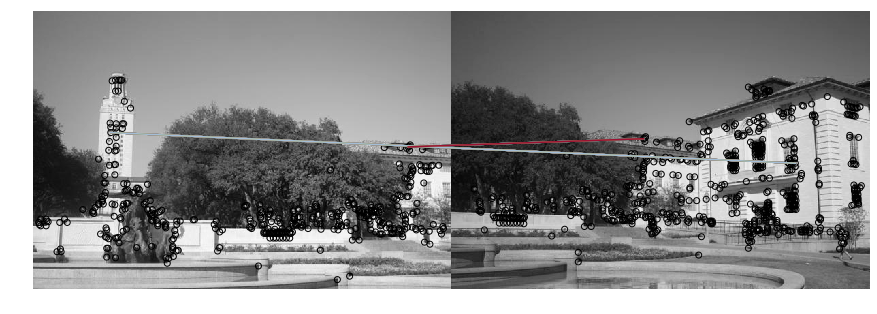

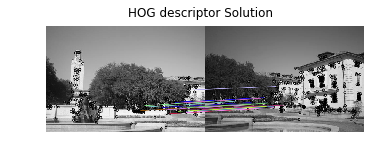

In [19]:
from panorama import ransac
H, robust_matches = ransac(keypoints1, keypoints2, matches, threshold=1)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plot_matches(ax, img1, img2, keypoints1, keypoints2, robust_matches)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_hog_ransac.png'))
plt.axis('off')
plt.title('HOG descriptor Solution')
plt.show()

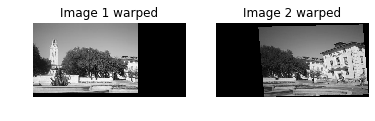

In [20]:
output_shape, offset = get_output_space(img1, [img2], [H])

# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
img1_mask = (img1_warped != -1) # Mask == 1 inside the image
img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
img2_mask = (img2_warped != -1) # Mask == 1 inside the image
img2_warped[~img2_mask] = 0     # Return background values to 0

# Plot warped images
plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('Image 1 warped')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_warped)
plt.title('Image 2 warped')
plt.axis('off')

plt.show()

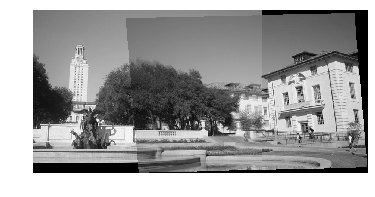

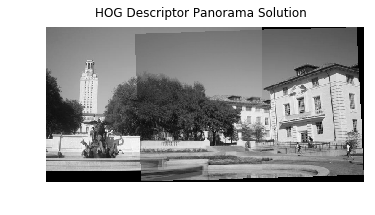

In [21]:
merged = img1_warped + img2_warped

# Track the overlap by adding the masks together
overlap = (img1_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           img2_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)
plt.imshow(normalized)
plt.axis('off')
plt.show()

plt.imshow(imread('solution_hog_panorama.png'))
plt.axis('off')
plt.title('HOG Descriptor Panorama Solution')
plt.show()

## Extra Credit: Better Image Merging
You will notice the blurry region and unpleasant lines in the middle of the final panoramic image. In the cell below, come up with a better merging scheme to make the panorama look more natural. Be creative!

Nếu chú bý ạn sẽ thấy những vùng bị nhờ và các đường thẳng nằm ở giữa ảnh panorama. Đoạn code bên dưới mô tả một cách để ghép ảnh đẹp hơn, tự nhiên hơn. Bạn hãy tự mình sáng tạo thêm các cách khác nhé !



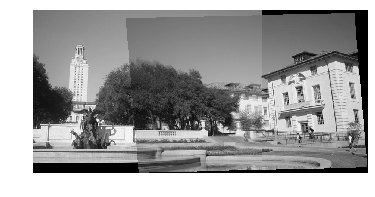

In [22]:
# Modify the code below

### YOUR CODE HERE
merged = img1_warped + img2_warped

overlap = (img1_mask * 1.0 + img2_mask)

output = merged / np.maximum(overlap, 1)
### END YOUR CODE

plt.imshow(output)
plt.axis('off')
plt.show()

## Extra Credit: Stitching Multiple Images
Work in the cell below to complete the code to stitch an ordered chain of images.

Given a sequence of $m$ images ($I_1, I_2,...,I_m$), take every neighboring pair of images and compute the transformation matrix which converts points from the coordinate frame of $I_{i+1}$ to the frame of $I_{i}$. Then, select a reference image $I_{ref}$, which is in the middle of the chain. We want our final panorama image to be in the coordinate frame of $I_{ref}$. So, for each $I_i$ that is not the reference image, we need a transformation matrix that will convert points in frame $i$ to frame $ref$.


Phần sau đây mô tả quy trình ghép nhiều ảnh (thay vì 2).

Giả sử đầu vào là $m$ ảnh theo thứ tự ($I_1, I_2,...,I_m$), ta lấy hai ảnh liên tiếp và tính ma trận biến đổi $H$ để chuyển từ hệ toạ độ của ảnh $I_{i+1}$ thành $I_{i}$. Sau đó, chọn một ảnh tham chiếu $I_{ref}$, nên chọn ảnh chính giữa $I_{m/2}$. Ta muốn ảnh panorama kết quả sẽ lấy theo toạ độ của ảnh $I_{ref}$. Vì thế, với mỗi ảnh $I_i$ không phải ảnh tham chiếu, ta cần một ma trận biến đổi để biến đổi các điểm trong ảnh $i$ về ảnh $ref$.


*-Hint:*
- If you are confused, you may want to review the Linear Algebra slides on how to combine the effects of multiple transformation matrices.
- The inverse of transformation matrix has the reverse effect. Please use [`numpy.linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) function whenever you want to compute matrix inverse.

*-Gợi ý:*
- Nếu bạn còn mơ hồ, hãy xem lại các slides liên quan đến đại số tuyến tính về cách tìm nhiều ma trận biến đổi.
- Nghịch đảo của ma trận biến đổi có thể bị hiệu ứng lề. Hãy sử dụng hàm [`numpy.linalg.inv`] thay vì sử dụng phép nghịch đảo (https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) khi muốn tính nghịch đảo ma trận.

In [23]:
img1 = imread('yosemite1.jpg', as_grey=True)
img2 = imread('yosemite2.jpg', as_grey=True)
img3 = imread('yosemite3.jpg', as_grey=True)
img4 = imread('yosemite4.jpg', as_grey=True)

# Detect keypoints in each image
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints3 = corner_peaks(harris_corners(img3, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints4 = corner_peaks(harris_corners(img4, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Describe keypoints
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc3 = describe_keypoints(img3, keypoints3,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc4 = describe_keypoints(img4, keypoints4,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match keypoints in neighboring images
matches12 = match_descriptors(desc1, desc2, 0.7)
matches23 = match_descriptors(desc2, desc3, 0.7)
matches34 = match_descriptors(desc3, desc4, 0.7)

### YOUR CODE HERE
### END YOUR CODE

895
(895, 25)
(1746, 25)
(895, 1746)
1746
(1746, 25)
(991, 25)
(1746, 991)
991
(991, 25)
(2820, 25)
(991, 2820)


In [24]:
# Visualize final panorama image
plt.imshow(panorama)
plt.axis('off')
plt.show()

NameError: name 'panorama' is not defined